# White Elephants Kill. Can we anticipate them?
# Final Project - Andrei Bartra and Angelo Cozzubo

## Contents:
1. Descriptive Analysis: Geographical Variation 
2. Descriptive Analysis: Target Variable
3. Pre Processing 
4. Machine Learning Analysis: Lasso, RF, features importance and fit

In [1]:
import gc
gc.enable()
import sys  
import os 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import imageio
#My function py
import my_fns as fn
#Visualize 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## 1. Descriptive Analysis: Geographical Variation
### Map (gif) for total PIM by region/year 

In [41]:
mapa_uni = pd.read_csv(r'..\data\clean\mapa_uni.csv')
mapa_multi = pd.read_csv(r'..\data\clean\mapa_multi.csv')

In [42]:
mapa_all = mapa_uni.merge(mapa_multi, on=['dpto', 'ANO_EJE'], how = 'left')

In [43]:
mapa_all['pim_tot_mill'] = (mapa_all['pim_proj_x'] + mapa_all['pim_proj_y'])/1000000
mapa_all = mapa_all[['pim_tot_mill', 'dpto', 'ANO_EJE']]

In [44]:
# set the filepath and load in a shapefile
shape_ = r'..\data\raw\ext\dptos\DEPARTAMENTOS.shp'
map_regions = gpd.read_file(shape_)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_regions.head()

,IDDPTO,DEPARTAMEN,CAPITAL,FUENTE,geometry
0,01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990..."
1,02,ANCASH,HUARAZ,INEI,"POLYGON ((-77.64692 -8.05086, -77.64669 -8.052..."
2,03,APURIMAC,ABANCAY,INEI,"POLYGON ((-73.74632 -13.17456, -73.74570 -13.1..."
3,04,AREQUIPA,AREQUIPA,INEI,"POLYGON ((-71.98109 -14.64062, -71.98093 -14.6..."
4,05,AYACUCHO,AYACUCHO,INEI,"POLYGON ((-74.34843 -12.17503, -74.35000 -12.1..."


In [45]:
#same regional code and merge 
mapa_all['ANO_EJE'] = mapa_all['ANO_EJE'].astype(int)
mapa_all['ID_DPTO'] = mapa_all['dpto'].apply(lambda x: str(x) if x > 9 else "0" + str(x))
merged = map_regions.set_index('IDDPTO').join(mapa_all.set_index('ID_DPTO'))
merged.head()

,DEPARTAMEN,CAPITAL,FUENTE,geometry,pim_tot_mill,dpto,ANO_EJE
01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990...",18.950712,1,2012
01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990...",26.107334,1,2013
01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990...",6.644427,1,2014
01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990...",8.585953,1,2015
01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990...",15.373802,1,2016


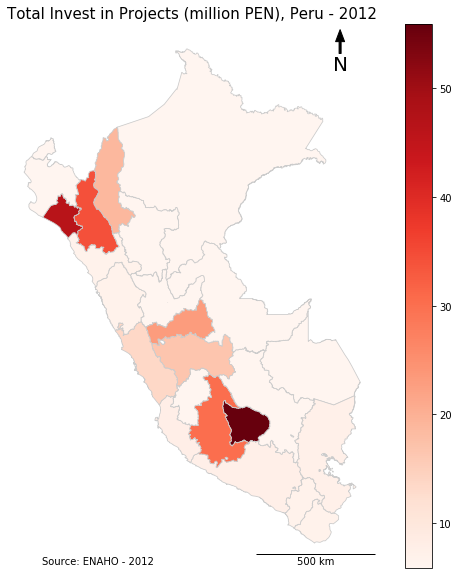

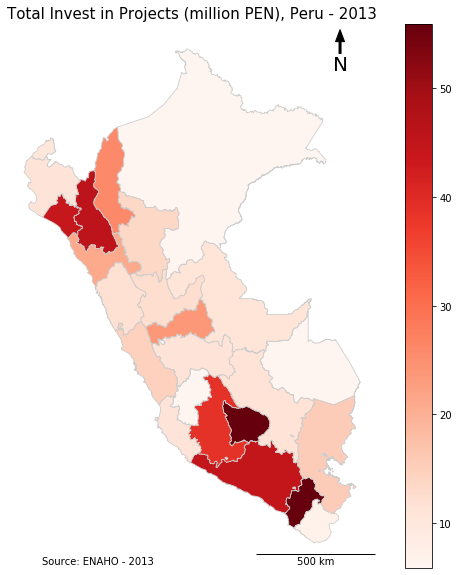

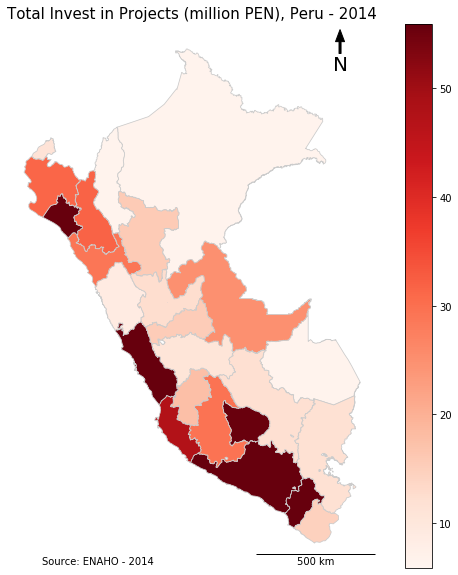

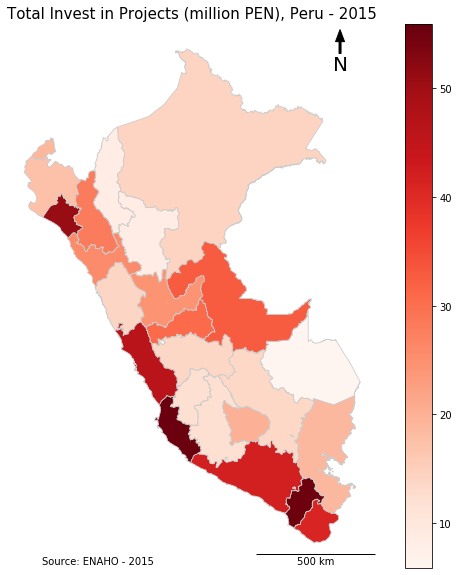

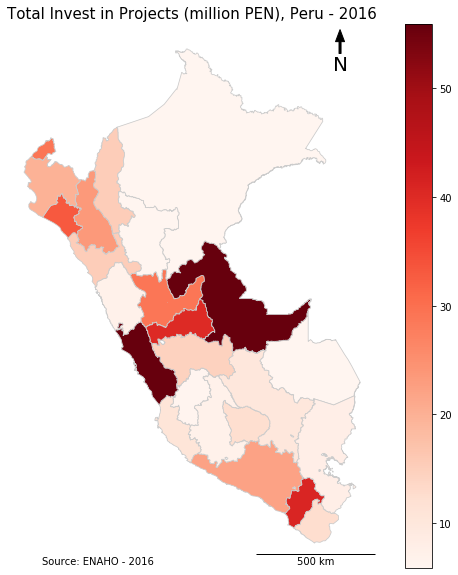

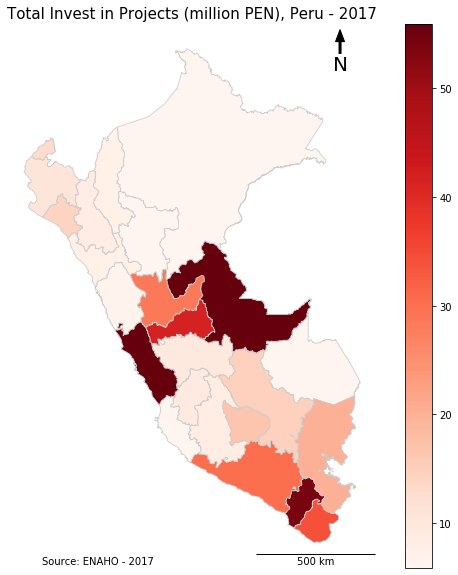

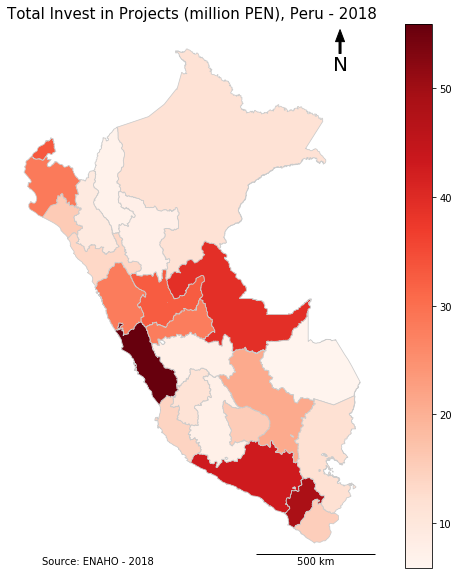

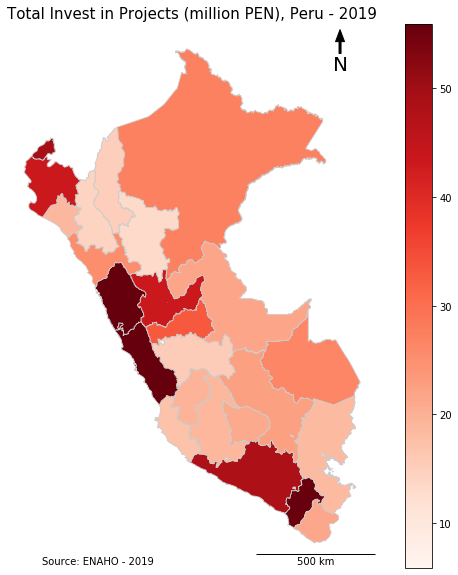

In [46]:
variable = 'pim_tot_mill'
color = 'Reds'
title = 'Amount in Project Investment (millions PEN), Peru - {}'.format('2012-2019')
maps = []

for year in range(2012,2020):
    title = 'Total Invest in Projects (million PEN), Peru - {}'.format(str(year))
    source = "Source: ENAHO - {}".format(str(year))
    vmin, vmax = merged.pim_tot_mill.quantile(0.10), merged.pim_tot_mill.quantile(0.90)
    map_ = fn.share_maps_cb(merged, 'ANO_EJE', year, variable, color, title, source, vmin, vmax, False)
    map_.savefig(r"..\results\maps\total_PIM_{}.png".format(str(year)))
    maps.append(imageio.imread(r"..\results\maps\total_PIM_{}.png".format(str(year))))
    os.remove(r"..\results\maps\total_PIM_{}.png".format(str(year)))

imageio.mimsave(r"..\results\maps\total_PIM_12-19.gif", maps, duration=0.9, subrectangles=True)
del merged

## 2. Descriptive Analysis: Target Variable
### CDF for PIM by electoral years 

In [7]:
full = pd.read_csv(r'..\2_data\clean\df.gz', compression='gzip')
full = full.loc[full.ANO_EJE > 2012]
full = full.loc[full.ANO_EJE < 2019]
print(full.shape)
full.head(1)

(634344, 871)


,CODIGO_UNICO,ANO_EJE,mes,FECHA_REGISTRO,FECHA_VIABLE_APROBADO,SEC_EJEC,dev_acc_proj,exec,dev_acc_ue,exec_ue,pim_proj,dev_proj,elect_year,first_year,elect_presi_year,first_presi_year,nv_1,nv_2,nv_3,st_3,st_5,st_6,st_7,st_10,st_11,st_13,st_16,st_26,st_36,st_37,st_99,st_100,st_101,ft_1,ft_2,ft_3,ft_4,ft_5,pim_st_year_3,pim_st_year_5,pim_st_year_6,pim_st_year_7,pim_st_year_10,pim_st_year_11,pim_st_year_13,pim_st_year_16,pim_st_year_26,pim_st_year_36,pim_st_year_37,pim_st_year_99,pim_st_year_100,pim_st_year_101,pim_st_proj_3,pim_st_proj_5,pim_st_proj_6,pim_st_proj_7,pim_st_proj_10,pim_st_proj_11,pim_st_proj_13,pim_st_proj_16,pim_st_proj_26,pim_st_proj_36,pim_st_proj_37,pim_st_proj_99,pim_st_proj_100,pim_st_proj_101,pim_ft_proj_1,pim_ft_proj_2,pim_ft_proj_3,pim_ft_proj_4,pim_ft_proj_5,pim_nv_proj_1,pim_nv_proj_2,pim_nv_proj_3,pim_st_proj_pr_3,pim_st_proj_pr_5,pim_st_proj_pr_6,pim_st_proj_pr_7,pim_st_proj_pr_10,pim_st_proj_pr_11,pim_st_proj_pr_13,pim_st_proj_pr_16,pim_st_proj_pr_26,pim_st_proj_pr_36,pim_st_proj_pr_37,pim_st_proj_pr_99,pim_st_proj_pr_100,pim_st_proj_pr_101,pim_ft_proj_pr_1,pim_ft_proj_pr_2,pim_ft_proj_pr_3,pim_ft_proj_pr_4,pim_ft_proj_pr_5,pim_nv_proj_pr_1,pim_nv_proj_pr_2,pim_nv_proj_pr_3,dev_acc_st_3,dev_acc_st_5,dev_acc_st_6,dev_acc_st_7,dev_acc_st_10,dev_acc_st_11,dev_acc_st_13,dev_acc_st_16,dev_acc_st_26,dev_acc_st_36,dev_acc_st_37,dev_acc_st_99,dev_acc_st_100,dev_acc_st_101,exec_st_3,exec_st_5,exec_st_6,exec_st_7,exec_st_10,exec_st_11,exec_st_13,exec_st_16,exec_st_26,exec_st_36,exec_st_37,exec_st_99,exec_st_100,exec_st_101,dev_ft_month_sh_1,dev_ft_month_sh_2,dev_ft_month_sh_3,dev_ft_month_sh_4,dev_ft_month_sh_5,dev_st_month_sh_3,dev_st_month_sh_5,dev_st_month_sh_6,dev_st_month_sh_7,dev_st_month_sh_10,dev_st_month_sh_11,dev_st_month_sh_13,dev_st_month_sh_16,dev_st_month_sh_26,dev_st_month_sh_36,dev_st_month_sh_37,dev_st_month_sh_99,dev_st_month_sh_100,dev_st_month_sh_101,dev_nv_month_sh_1,dev_nv_month_sh_2,dev_nv_month_sh_3,target,ok,year,month,day,dev_proj_12m_last,dev_ft_month_sh_1_12m_last,dev_ft_month_sh_2_12m_last,dev_ft_month_sh_3_12m_last,dev_ft_month_sh_4_12m_last,dev_ft_month_sh_5_12m_last,dev_st_month_sh_3_12m_last,dev_st_month_sh_5_12m_last,dev_st_month_sh_6_12m_last,dev_st_month_sh_7_12m_last,dev_st_month_sh_10_12m_last,dev_st_month_sh_11_12m_last,dev_st_month_sh_13_12m_last,dev_st_month_sh_16_12m_last,dev_st_month_sh_26_12m_last,dev_st_month_sh_36_12m_last,dev_st_month_sh_37_12m_last,dev_st_month_sh_99_12m_last,dev_st_month_sh_100_12m_last,dev_st_month_sh_101_12m_last,dev_nv_month_sh_1_12m_last,dev_nv_month_sh_2_12m_last,dev_nv_month_sh_3_12m_last,dev_acc_st_3_3m_lag,dev_acc_st_3_6m_lag,dev_acc_st_3_12m_lag,dev_acc_st_5_3m_lag,dev_acc_st_5_6m_lag,dev_acc_st_5_12m_lag,dev_acc_st_6_3m_lag,dev_acc_st_6_6m_lag,dev_acc_st_6_12m_lag,dev_acc_st_7_3m_lag,dev_acc_st_7_6m_lag,dev_acc_st_7_12m_lag,dev_acc_st_10_3m_lag,dev_acc_st_10_6m_lag,dev_acc_st_10_12m_lag,dev_acc_st_11_3m_lag,dev_acc_st_11_6m_lag,dev_acc_st_11_12m_lag,dev_acc_st_13_3m_lag,dev_acc_st_13_6m_lag,dev_acc_st_13_12m_lag,dev_acc_st_16_3m_lag,dev_acc_st_16_6m_lag,dev_acc_st_16_12m_lag,dev_acc_st_26_3m_lag,dev_acc_st_26_6m_lag,dev_acc_st_26_12m_lag,dev_acc_st_36_3m_lag,dev_acc_st_36_6m_lag,dev_acc_st_36_12m_lag,dev_acc_st_37_3m_lag,dev_acc_st_37_6m_lag,dev_acc_st_37_12m_lag,dev_acc_st_99_3m_lag,dev_acc_st_99_6m_lag,dev_acc_st_99_12m_lag,dev_acc_st_100_3m_lag,dev_acc_st_100_6m_lag,dev_acc_st_100_12m_lag,dev_acc_st_101_3m_lag,dev_acc_st_101_6m_lag,dev_acc_st_101_12m_lag,dev_acc_proj_3m_mean,dev_acc_proj_6m_mean,dev_acc_proj_12m_mean,exec_3m_mean,exec_6m_mean,exec_12m_mean,dev_proj_3m_mean,dev_proj_6m_mean,dev_proj_12m_mean,dev_acc_st_3_3m_mean,dev_acc_st_3_6m_mean,dev_acc_st_3_12m_mean,dev_acc_st_5_3m_mean,dev_acc_st_5_6m_mean,dev_acc_st_5_12m_mean,dev_acc_st_6_3m_mean,dev_acc_st_6_6m_mean,dev_acc_st_6_12m_mean,dev_acc_st_7_3m_mean,dev_acc_st_7_6m_mean,dev_acc_st_7_12m_mean,dev_acc_st_10_3m_mean,dev_acc_st_10_6m_mean,dev_acc_st_10_12m_mean,dev_acc_s

In [48]:
full['ANO_EJE'] = full['ANO_EJE'].astype(int)
full['pim_proj_mll'] = full['pim_proj']/1000000

In [49]:
full['pim_proj_mll'].describe().apply(lambda x: format(x, 'f'))

count    634344.000000
mean          2.281498
std          16.968200
min           0.000001
25%           0.034500
50%           0.220661
75%           1.200000
max        1870.600571
Name: pim_proj_mll, dtype: object

### 2.1 CDF for Investment by electoral years 

In [50]:
trim = 0.015
trimmed = full[full.pim_proj_mll < full.pim_proj_mll.quantile(1-trim)]
variable = 'pim_proj_mll'
all_years = [x for x in range(2012,2020)]
election_years_pres = [2015, 2016]
election_years_reg = [2012, 2013, 2016, 2017]
title_pres = 'Investment in Projects by Presidential Elections, Peru 2012-2019'
title_reg = 'Investment in Projects by Regional Gov. Elections, Peru 2012-2019'
xlab = 'Millions PEN, Nominal Value'
ylab = 'Cumulative Probability'
source = "Note: Trimmed at the upper {}%. Source: MEF Administrative Data {}-{}".format(
         str(int(trim*100)), all_years[0], all_years[-1])

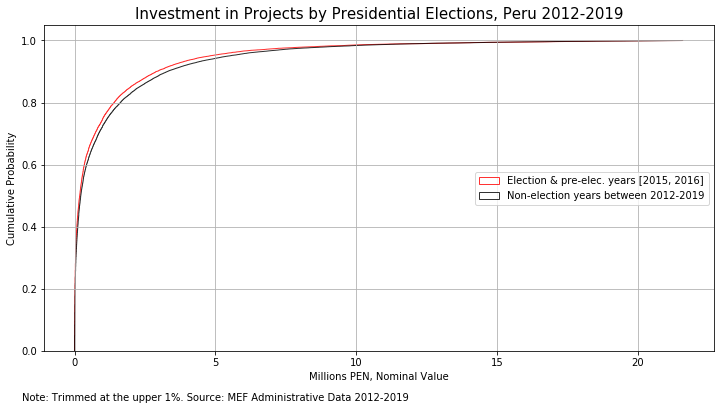

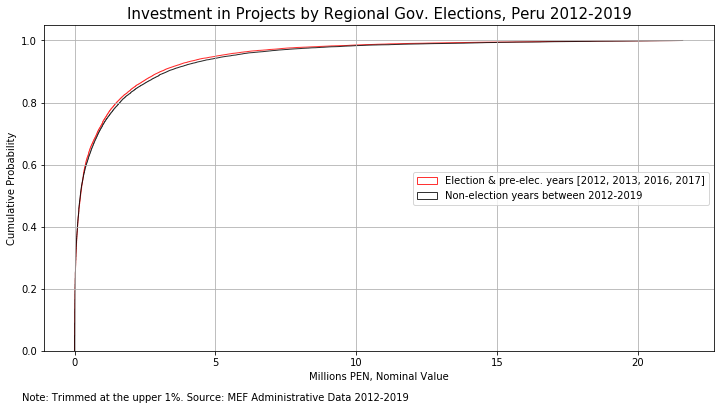

In [51]:
fn.cdf_elec_years(trimmed, 'ANO_EJE', all_years, variable, election_years_pres, title_pres, xlab, ylab, source)
fn.cdf_elec_years(trimmed, 'ANO_EJE', all_years, variable, election_years_reg, title_reg, xlab, ylab, source)
full = full.drop(columns='pim_proj_mll')

### 2.1 CDF for Target by electoral years 

In [52]:
variable = 'target'
all_years = [x for x in range(2012,2020)]
election_years_pres = [2015, 2016]
election_years_reg = [2012, 2013, 2016, 2017]
title_pres = 'Cumulative Execution of Projects by Presidential Elections, Peru 2012-2019'
title_reg = 'Cumulative Execution of Projects by Regional Gov. Elections, Peru 2012-2019'
xlab = 'Proportion of budget executed'
ylab = 'Cumulative Probability'
source = "Source: MEF Administrative Data {}-{}".format(all_years[0], all_years[-1])

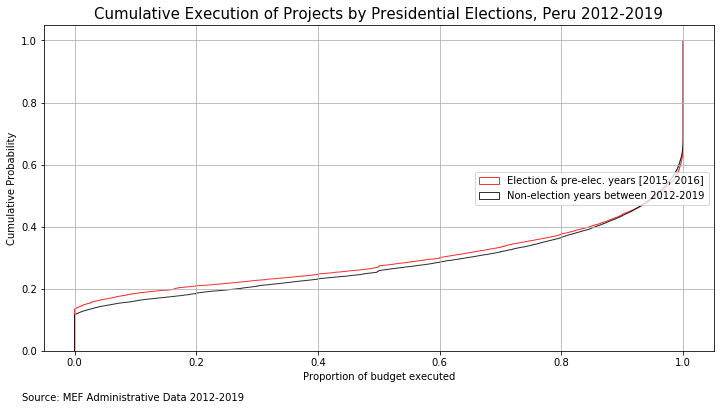

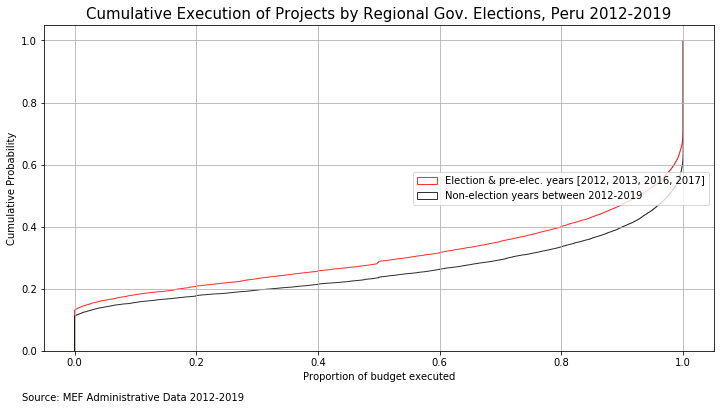

In [53]:
fn.cdf_elec_years(full, 'ANO_EJE', all_years, 'target', election_years_pres, title_pres, xlab, ylab, source)
fn.cdf_elec_years(full, 'ANO_EJE', all_years, 'target', election_years_reg, title_reg, xlab, ylab, source)

## 3. Preprocessing 

In [8]:
rows, cols = full.shape
desc = full.describe()
all_cols = list(full.columns)
no_impute = ['CODIGO_UNICO', 'ANO_EJE', 'mes', 'FECHA_REGISTRO', 'class',
             'FECHA_VIABLE_APROBADO', 'target', 'ok', 'year', 'month' ,'day' 
             'reg_count', 'tag_proy', 'SEC_EJEC', 'weight']

full.head()

,CODIGO_UNICO,ANO_EJE,mes,FECHA_REGISTRO,FECHA_VIABLE_APROBADO,SEC_EJEC,dev_acc_proj,exec,dev_acc_ue,exec_ue,pim_proj,dev_proj,elect_year,first_year,elect_presi_year,first_presi_year,nv_1,nv_2,nv_3,st_3,st_5,st_6,st_7,st_10,st_11,st_13,st_16,st_26,st_36,st_37,st_99,st_100,st_101,ft_1,ft_2,ft_3,ft_4,ft_5,pim_st_year_3,pim_st_year_5,pim_st_year_6,pim_st_year_7,pim_st_year_10,pim_st_year_11,pim_st_year_13,pim_st_year_16,pim_st_year_26,pim_st_year_36,pim_st_year_37,pim_st_year_99,pim_st_year_100,pim_st_year_101,pim_st_proj_3,pim_st_proj_5,pim_st_proj_6,pim_st_proj_7,pim_st_proj_10,pim_st_proj_11,pim_st_proj_13,pim_st_proj_16,pim_st_proj_26,pim_st_proj_36,pim_st_proj_37,pim_st_proj_99,pim_st_proj_100,pim_st_proj_101,pim_ft_proj_1,pim_ft_proj_2,pim_ft_proj_3,pim_ft_proj_4,pim_ft_proj_5,pim_nv_proj_1,pim_nv_proj_2,pim_nv_proj_3,pim_st_proj_pr_3,pim_st_proj_pr_5,pim_st_proj_pr_6,pim_st_proj_pr_7,pim_st_proj_pr_10,pim_st_proj_pr_11,pim_st_proj_pr_13,pim_st_proj_pr_16,pim_st_proj_pr_26,pim_st_proj_pr_36,pim_st_proj_pr_37,pim_st_proj_pr_99,pim_st_proj_pr_100,pim_st_proj_pr_101,pim_ft_proj_pr_1,pim_ft_proj_pr_2,pim_ft_proj_pr_3,pim_ft_proj_pr_4,pim_ft_proj_pr_5,pim_nv_proj_pr_1,pim_nv_proj_pr_2,pim_nv_proj_pr_3,dev_acc_st_3,dev_acc_st_5,dev_acc_st_6,dev_acc_st_7,dev_acc_st_10,dev_acc_st_11,dev_acc_st_13,dev_acc_st_16,dev_acc_st_26,dev_acc_st_36,dev_acc_st_37,dev_acc_st_99,dev_acc_st_100,dev_acc_st_101,exec_st_3,exec_st_5,exec_st_6,exec_st_7,exec_st_10,exec_st_11,exec_st_13,exec_st_16,exec_st_26,exec_st_36,exec_st_37,exec_st_99,exec_st_100,exec_st_101,dev_ft_month_sh_1,dev_ft_month_sh_2,dev_ft_month_sh_3,dev_ft_month_sh_4,dev_ft_month_sh_5,dev_st_month_sh_3,dev_st_month_sh_5,dev_st_month_sh_6,dev_st_month_sh_7,dev_st_month_sh_10,dev_st_month_sh_11,dev_st_month_sh_13,dev_st_month_sh_16,dev_st_month_sh_26,dev_st_month_sh_36,dev_st_month_sh_37,dev_st_month_sh_99,dev_st_month_sh_100,dev_st_month_sh_101,dev_nv_month_sh_1,dev_nv_month_sh_2,dev_nv_month_sh_3,target,ok,year,month,day,dev_proj_12m_last,dev_ft_month_sh_1_12m_last,dev_ft_month_sh_2_12m_last,dev_ft_month_sh_3_12m_last,dev_ft_month_sh_4_12m_last,dev_ft_month_sh_5_12m_last,dev_st_month_sh_3_12m_last,dev_st_month_sh_5_12m_last,dev_st_month_sh_6_12m_last,dev_st_month_sh_7_12m_last,dev_st_month_sh_10_12m_last,dev_st_month_sh_11_12m_last,dev_st_month_sh_13_12m_last,dev_st_month_sh_16_12m_last,dev_st_month_sh_26_12m_last,dev_st_month_sh_36_12m_last,dev_st_month_sh_37_12m_last,dev_st_month_sh_99_12m_last,dev_st_month_sh_100_12m_last,dev_st_month_sh_101_12m_last,dev_nv_month_sh_1_12m_last,dev_nv_month_sh_2_12m_last,dev_nv_month_sh_3_12m_last,dev_acc_st_3_3m_lag,dev_acc_st_3_6m_lag,dev_acc_st_3_12m_lag,dev_acc_st_5_3m_lag,dev_acc_st_5_6m_lag,dev_acc_st_5_12m_lag,dev_acc_st_6_3m_lag,dev_acc_st_6_6m_lag,dev_acc_st_6_12m_lag,dev_acc_st_7_3m_lag,dev_acc_st_7_6m_lag,dev_acc_st_7_12m_lag,dev_acc_st_10_3m_lag,dev_acc_st_10_6m_lag,dev_acc_st_10_12m_lag,dev_acc_st_11_3m_lag,dev_acc_st_11_6m_lag,dev_acc_st_11_12m_lag,dev_acc_st_13_3m_lag,dev_acc_st_13_6m_lag,dev_acc_st_13_12m_lag,dev_acc_st_16_3m_lag,dev_acc_st_16_6m_lag,dev_acc_st_16_12m_lag,dev_acc_st_26_3m_lag,dev_acc_st_26_6m_lag,dev_acc_st_26_12m_lag,dev_acc_st_36_3m_lag,dev_acc_st_36_6m_lag,dev_acc_st_36_12m_lag,dev_acc_st_37_3m_lag,dev_acc_st_37_6m_lag,dev_acc_st_37_12m_lag,dev_acc_st_99_3m_lag,dev_acc_st_99_6m_lag,dev_acc_st_99_12m_lag,dev_acc_st_100_3m_lag,dev_acc_st_100_6m_lag,dev_acc_st_100_12m_lag,dev_acc_st_101_3m_lag,dev_acc_st_101_6m_lag,dev_acc_st_101_12m_lag,dev_acc_proj_3m_mean,dev_acc_proj_6m_mean,dev_acc_proj_12m_mean,exec_3m_mean,exec_6m_mean,exec_12m_mean,dev_proj_3m_mean,dev_proj_6m_mean,dev_proj_12m_mean,dev_acc_st_3_3m_mean,dev_acc_st_3_6m_mean,dev_acc_st_3_12m_mean,dev_acc_st_5_3m_mean,dev_acc_st_5_6m_mean,dev_acc_st_5_12m_mean,dev_acc_st_6_3m_mean,dev_acc_st_6_6m_mean,dev_acc_st_6_12m_mean,dev_acc_st_7_3m_mean,dev_acc_st_7_6m_mean,dev_acc_st_7_12m_mean,dev_acc_st_10_3m_mean,dev_acc_st_10_6m_mean,dev_acc_st_10_12m_mean,dev_acc_s

### 3.0 A variable we missed

In [9]:
class_dummy = pd.get_dummies(full['class'])
full = pd.concat([full, class_dummy], axis=1)
del class_dummy

### 3.1 Missing imputations and creation of dummies

In [10]:
mv_dummy_impute = ['dev_proj_12m_last', 'dev_acc_st_3_3m_lag', 'dev_acc_st_3_6m_lag', 'dev_acc_st_3_12m_lag', 'agua_inadec']
mv_impute = [col for col in desc.columns if desc.loc['count', col] < rows and col not in mv_dummy_impute]
full = fn.mv_treat(full, mv_dummy_impute, 0, dummy=True)
full = fn.mv_treat(full, mv_impute, 0, dummy=False)

KeyboardInterrupt: 

In [ ]:
desc = full.describe()
desc

### 3.2 Outlier imputation with percentile 99

In [ ]:
out_to_clean = [var for var in full.columns if var not in no_impute and var.startswith('mv_') == False and
                                                   (var.startswith('dev_acc_') == True or 
                                                    var == 'dev_proj')]
full = fn.outliers_imputation(full, 0.01, out_to_clean)

### 3.3 Removing constant variables

In [ ]:
desc = full.describe()
discard = [col for col in desc.columns if np.isclose(desc.loc['std', col], 0) | np.isnan(desc.loc['std', col]) ]
discard

### 3.3 Predictors and target variable

In [ ]:
x_vars = [var for var in full.columns if var not in no_impute and var.startswith('mv_') == False and var not in discard ]

### 3.4 Correlation filter at 0.25

In [ ]:
uncorr_vars_20 = fn.low_corr_vars(full[x_vars], full['target'].reset_index(), 0.20)

In [ ]:
len(uncorr_vars_20)

### 3.6 Including dummy variables if var was imputted. Correlation filter at 0.8

In [ ]:
mv_x_vars = [var for var in full.columns if var.startswith('mv_')]
uncorr_mv_vars_08 = fn.low_corr_vars(full[mv_x_vars], full['target'].reset_index(), 0.8)
uncorr_mv_vars_08

### 3.8 Final predictors

In [ ]:
final_vars = list(uncorr_vars_20) + list(uncorr_mv_vars_08)
desc = full[final_vars].describe()
desc

### 3.8 Polynomials

In [ ]:
aux = [col for col in out_to_clean if col in final_vars and col.endswith('_delta') == False or col == 'MONTO_VIABLE_APROBADO' ]
log_vars = [col for col in aux if desc.loc['min', col] >= 0]
square_vars = [col for col in final_vars if any([col.startswith(s) for s in ['mv_', 'ft_', 'st_', 'mes_']]) == False]

for var in log_vars:
    full[var] = np.log(full[var] +1)
    
for var in square_vars:
    full[var + '_sq'] = full[var]**2  

In [ ]:
reg_vars = final_vars + [var + '_sq' for var in square_vars]

## 4. Machine Learning Analysis

In [82]:
import numpy as np
from scipy.stats import uniform as sp_rand

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split

### 4.1 Splitting and checking complete dataset

In [112]:

oot = full.loc[full.ANO_EJE == 2018, reg_vars + ['target']]
X_train, X_test, y_train, y_test = train_test_split(full.loc[full.ANO_EJE < 2018, reg_vars], 
                                                    full.loc[full.ANO_EJE < 2018, 'target'], 
                                                    test_size= 0.2)
y_train, y_test = y_train.reset_index(), y_test.reset_index()

### 4.2 Correlation of predictor vars 

Text(0.5, 1, 'Correlation of Selected Variables')

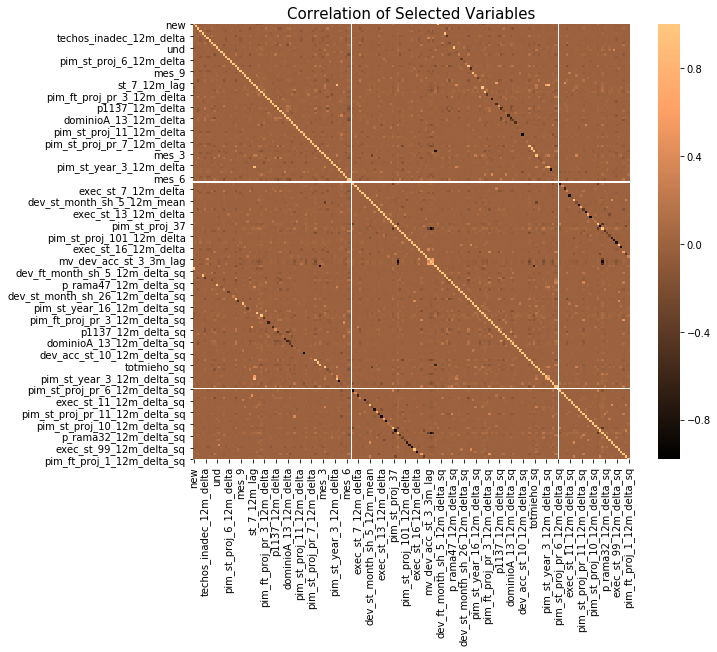

In [86]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='copper',
            square=True, ax=ax)
plt.title('Correlation of Selected Variables', fontdict={'fontsize': 15, 'fontweight': 3})

### 4.3 Machine Learning Algorithms: LASSO, GridSearchCV and Best Model

In [88]:
from sklearn import linear_model

# Lasso 
lasso = linear_model.Lasso()

# Parameters 
alphas = np.arange(0.01, 1.05, 0.5).tolist()
params = {'alpha': alphas}

# K-Fold Cross Validation
k = 5

grid_search_cv = GridSearchCV(estimator=lasso, 
                          param_grid=params, 
                          cv=k,
                          scoring= 'r2',
                          return_train_score=True,
                          n_jobs = 5, 
                          verbose = 10)

grid_model_result = grid_search_cv.fit(X_train, y_train['target']) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed: 12.6min remaining: 11.0min
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed: 12.6min remaining:  6.3min
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed: 18.9min remaining:  4.7min
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 18.9min finished
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30178.344095712786, tolerance: 6.214517141049339
  positive)


In [89]:
# CV Results
cv_results = pd.DataFrame(grid_model_result.cv_results_)
cv_results = cv_results[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']] 
cv_results

,params,mean_test_score,mean_train_score,rank_test_score
0,{'alpha': 0.01},-2.726886,0.061266,3
1,{'alpha': 0.51},0.015139,0.015374,1
2,{'alpha': 1.01},0.012721,0.012950,2


In [90]:
# Best Model
cv_results.sort_values(by=['rank_test_score'], ascending=True).head(1)

,params,mean_test_score,mean_train_score,rank_test_score
1,{'alpha': 0.51},0.015139,0.015374,1


In [91]:
# Best Model
best_lasso = grid_model_result.best_estimator_
print("BEST MODEL IN TRAIN:", best_lasso)
print(grid_model_result.best_params_)
print(grid_model_result.best_score_)

BEST MODEL IN TRAIN: Lasso(alpha=0.51, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 0.51}
0.015138663167981691


In [114]:

y_hat_test =  best_lasso.predict(X_test)
y_hat_train =  best_lasso.predict(X_train)
y_hat_oot =  best_lasso.predict(oot[reg_vars])
# Assign 1 to values >1 and 0 to values < 0 
y_hat_test[y_hat_test > 1] = 1
y_hat_test[y_hat_test < 0] = 0

y_hat_train[y_hat_train > 1] = 1
y_hat_train[y_hat_train < 0] = 0

y_hat_oot[y_hat_oot > 1] = 1
y_hat_oot[y_hat_oot< 0] = 0

In [117]:
# R2 
print('Train: ', r2_score(y_train['target'], y_hat_train))
print('Test: ', r2_score(y_test['target'], y_hat_test))
print('OOT: ', r2_score(oot['target'], y_hat_oot))

Train:  0.01585213190883772
Test:  0.014686506290388923
OOT:  -0.05936086650476402


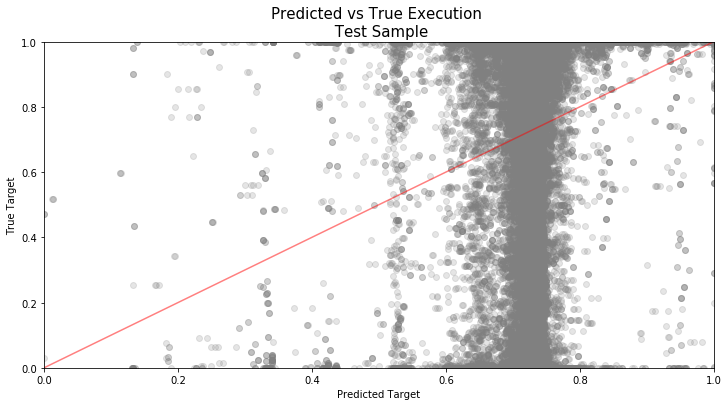

In [118]:
# Scatter 
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(y_hat_test, y_test['target'],  color='gray', alpha=0.2)
plt.xlim(0, 1)
plt.ylim(0, 1)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='r', alpha = 0.5)
ax.set_xlabel('Predicted Target')
ax.set_ylabel('True Target')
plt.title('Predicted vs True Execution - Test Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

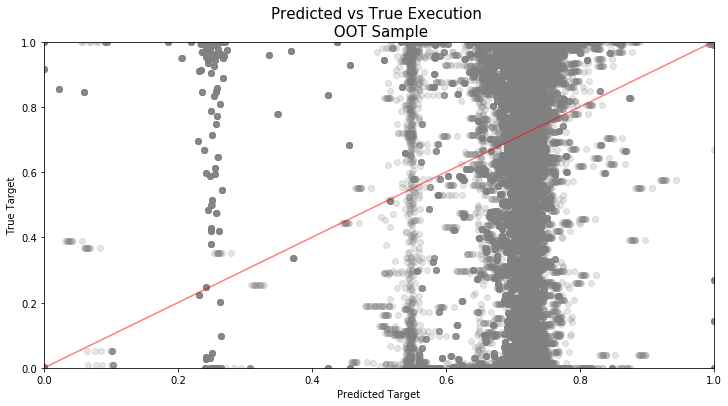

In [119]:
# Scatter 
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(y_hat_oot, y_oot['target'],  color='gray', alpha=0.2)
plt.xlim(0, 1)
plt.ylim(0, 1)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='r', alpha = 0.5)
ax.set_xlabel('Predicted Target')
ax.set_ylabel('True Target')
plt.title('Predicted vs True Execution - OOT Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

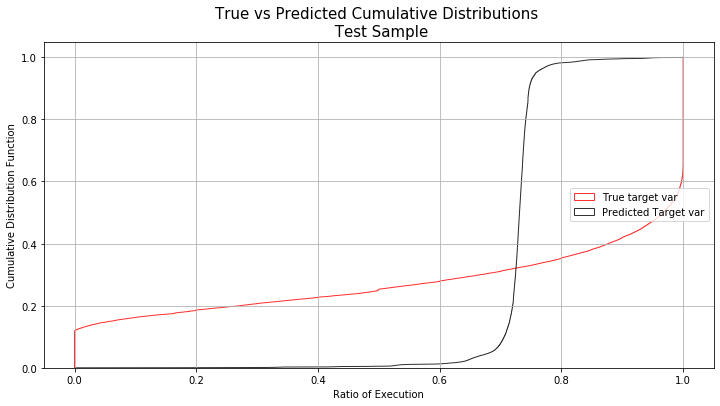

In [101]:
#CDF Graph 
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 6))

n, bins, patches = ax.hist(y_test['target'], 5000, density=1, 
                            histtype='step', alpha=0.8, color='r',
                            cumulative=True, label='True target var')
# Overlay non eleciton years .
ax.hist(y_hat_test, 5000, density=1, 
        histtype='step', cumulative=True, alpha=0.8, color='k', 
        label='Predicted Target var')

axpolygons = [poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)]
for poly in axpolygons:
    poly.set_xy(poly.get_xy()[:-1])
ax.grid(True)
ax.legend(loc='right')
ax.set_xlabel('Ratio of Execution')
ax.set_ylabel('Cumulative Distribution Function')
plt.title('True vs Predicted Cumulative Distributions - Test Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

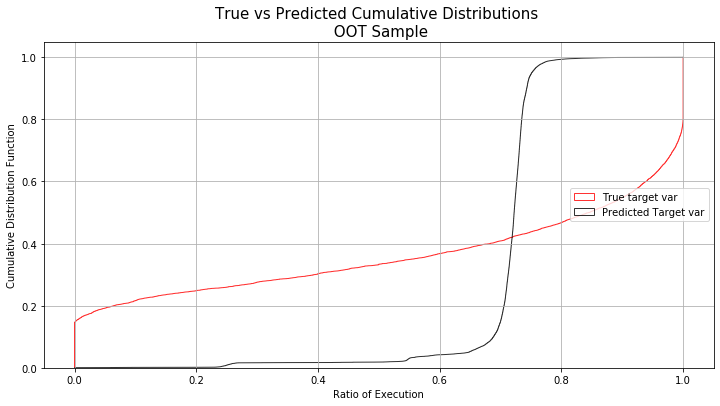

In [102]:
#CDF Graph 
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 6))

n, bins, patches = ax.hist(y_oot['target'], 5000, density=1, 
                            histtype='step', alpha=0.8, color='r',
                            cumulative=True, label='True target var')
# Overlay non eleciton years .
ax.hist(y_hat_oot, 5000, density=1, 
        histtype='step', cumulative=True, alpha=0.8, color='k', 
        label='Predicted Target var')

axpolygons = [poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)]
for poly in axpolygons:
    poly.set_xy(poly.get_xy()[:-1])
ax.grid(True)
ax.legend(loc='right')
ax.set_xlabel('Ratio of Execution')
ax.set_ylabel('Cumulative Distribution Function')
plt.title('True vs Predicted Cumulative Distributions - OOT Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

### 4.4 Machine Learning Algorithms: Random Forest, GridSearchCV and Best Model

In [126]:
X_oot = full.loc[full.ANO_EJE == 2018, final_vars]
y_oot = full.loc[full.ANO_EJE == 2018, 'target'].reset_index()
X_train, X_test, y_train, y_test = train_test_split(full.loc[full.ANO_EJE < 2018, final_vars], 
                                                    full.loc[full.ANO_EJE < 2018, 'target'], 
                                                    test_size= 0.2)
y_train, y_test, y_oot = y_train.reset_index(), y_test.reset_index(), y_oot.reset_index()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regression
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

# Parameters 
params = {
    'n_estimators': [100, 200],
    'min_samples_split': [100, 200],
    'min_samples_leaf': [50, 100],
    'max_depth': [50]}

# K-Fold Cross Validation
k = 5

fgrid_search_cv = GridSearchCV(estimator=rf, 
                          param_grid=params, 
                          cv=k,
                          scoring= 'r2',
                          return_train_score=True,
                          n_jobs = -1, 
                          verbose = 10)

fgrid_model_result = fgrid_search_cv.fit(X_train, y_train['target']) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 63.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 92.4min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed: 93.4min remaining: 76.5min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed: 121.1min remaining: 58.3min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 122.6min remaining: 30.7min


In [ ]:
# Results 
fcv_results = pd.DataFrame(fgrid_model_result.cv_results_)
fcv_results = fcv_results[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']] 
fcv_results.sort_values(by=['rank_test_score'], ascending=True).head(1)

In [ ]:
# Best Model
best_rf = fgrid_model_result.best_estimator_
print("BEST MODEL IN TRAIN:", best_rf)
print(fgrid_model_result.best_params_)
print(fgrid_model_result.best_score_)

In [ ]:
# R2 
y_hat_test = best_rf.predict(X_test)
y_hat_train =   best_rf.predict(X_train)
y_hat_oot =   best_rf.predict(X_oot)
print('Train: ', r2_score(y_train['target'], y_hat_train))
print('Test: ', r2_score(y_test['target'], y_hat_test))
print('OOT: ', r2_score(y_oot['target'], y_hat_oot))

In [ ]:
# Assign 1 to values >1 and 0 to values < 0 
y_hat_test[y_hat_test > 1] = 1
y_hat_test[y_hat_test < 0] = 0
y_hat_train[y_hat_train > 1] = 1
y_hat_train[y_hat_train < 0] = 0
y_hat_oot[y_hat_train > 1] = 1
y_hat_oot[y_hat_train < 0] = 0

In [ ]:
# Scatter 
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(y_hat_test, y_test['target'],  color='gray', alpha=0.2)
plt.xlim(0, 1)
plt.ylim(0, 1)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='r', alpha = 0.5)
ax.set_xlabel('Predicted Target')
ax.set_ylabel('True Target')
ax.title('True vs Predicted Execution \n Test Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

In [ ]:
# Scatter 
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(y_hat_oot, y_oot['target'],  color='gray', alpha=0.2)
plt.xlim(0, 1)
plt.ylim(0, 1)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='r', alpha = 0.5)
ax.set_xlabel('Predicted Target')
ax.set_ylabel('True Target')
ax.title('True vs Predicted Execution \n OOT Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

In [ ]:
#CDF Graph 
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 6))

n, bins, patches = ax.hist(y_test['target'], 5000, density=1, 
                            histtype='step', alpha=0.8, color='r',
                            cumulative=True, label='True target var')
# Overlay non eleciton years .
ax.hist(y_hat_test, 5000, density=1, 
        histtype='step', cumulative=True, alpha=0.8, color='k', 
        label='Predicted Target var')

axpolygons = [poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)]
for poly in axpolygons:
    poly.set_xy(poly.get_xy()[:-1])
ax.grid(True)
ax.legend(loc='right')
ax.set_xlabel('Ratio of Execution')
ax.set_ylabel('Cumulative Distribution Function')
ax.title('True vs Predicted Cumulative Distribution \n Test Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

In [ ]:
#CDF Graph 
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 6))

n, bins, patches = ax.hist(y_oot['target'], 5000, density=1, 
                            histtype='step', alpha=0.8, color='r',
                            cumulative=True, label='True target var')
# Overlay non eleciton years .
ax.hist(y_hat_oot, 5000, density=1, 
        histtype='step', cumulative=True, alpha=0.8, color='k', 
        label='Predicted Target var')

axpolygons = [poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)]
for poly in axpolygons:
    poly.set_xy(poly.get_xy()[:-1])
ax.grid(True)
ax.legend(loc='right')
ax.set_xlabel('Ratio of Execution')
ax.set_ylabel('Cumulative Distribution Function')
ax.title('True vs Predicted Cumulative Distribution \n OOT Sample', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()

### 4.5 Model Fit and Feature Importance

In [ ]:
f, ax = plt.subplots(figsize=(16, 8))
plt.bar(range(len(final_vars)),model.feature_importances_, color='peru')
plt.xticks(range(len(final_vars)), final_vars, rotation=65)
ax.title('Variable Importance', fontdict={'fontsize': 15, 'fontweight': 3})
plt.show()